(ch8:vnviasgm)=
# Vertex Nomination For Two Networks

Back in spectral vertex nomination in {numref}`ch7:vn`, you learned about the vertex nomination problem when you had one network. Now, we're going to reshape this problem a little bit.

To do this, we're going to turn to a classic example: school networks. First, you have the friends lists of 50 students from a popular social networking site. For any two individual students in the school, there is a probability of $0.5$ that they are friends on the social networking site. 

Separately, you also conduct a survey of the students at the school. The nodes are the $50$ students students from the school. You poll the $50$ students, and ask them who their friends are. For any given pair of students, an edge exists if either of the two students listed they were friends with the other. As it turns out, whether people are friends in real life is highly correlated with whether they are friends on the social network, so you think it seems reasonable to model these two networks as $\rho$-$ER_{100}(p)$ networks. For your purposes, just pick $p=0.5$ so you can generate some simulated data, and $\rho = 0.9$ (high correlation).

The realization of the network you are given will be called your social network, and looks like this:

In [1]:
from graspologic.simulations import er_corr
import numpy as np

directed = False
loops = False

n = 50; p = 0.5
rho = 0.9

Asoc, Asurvey = er_corr(n, p, rho, directed=directed, loops=loops)

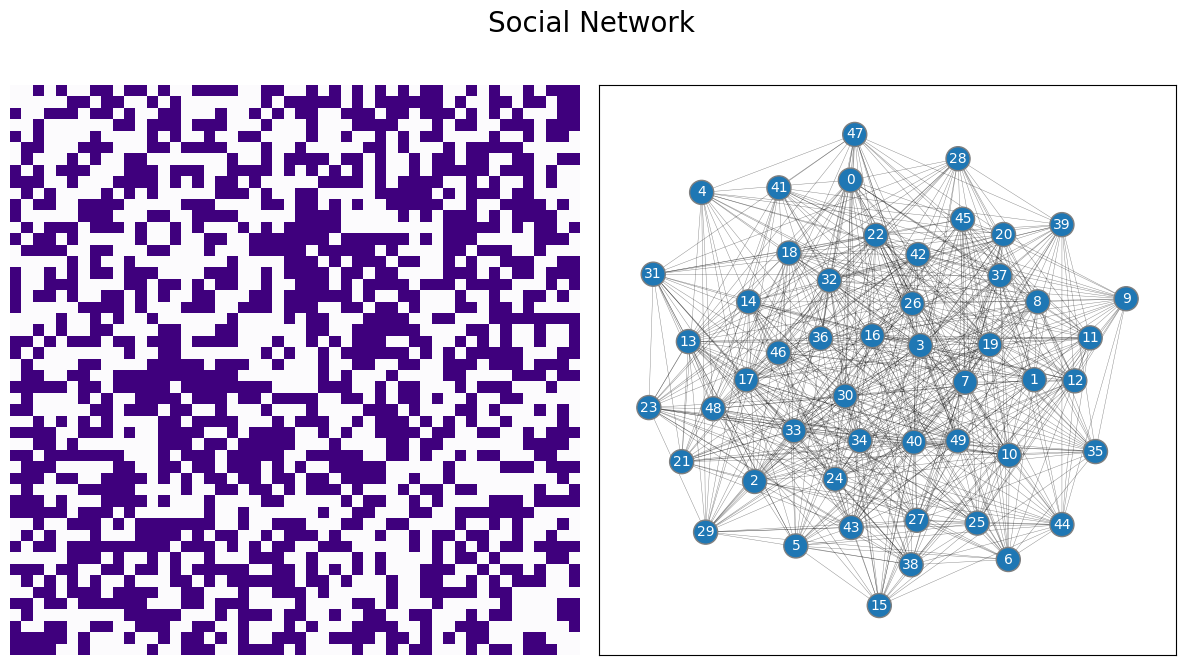

In [2]:
from graphbook_code import draw_multiplot
from matplotlib import pyplot as plt

draw_multiplot(Asoc, title="Social Network");

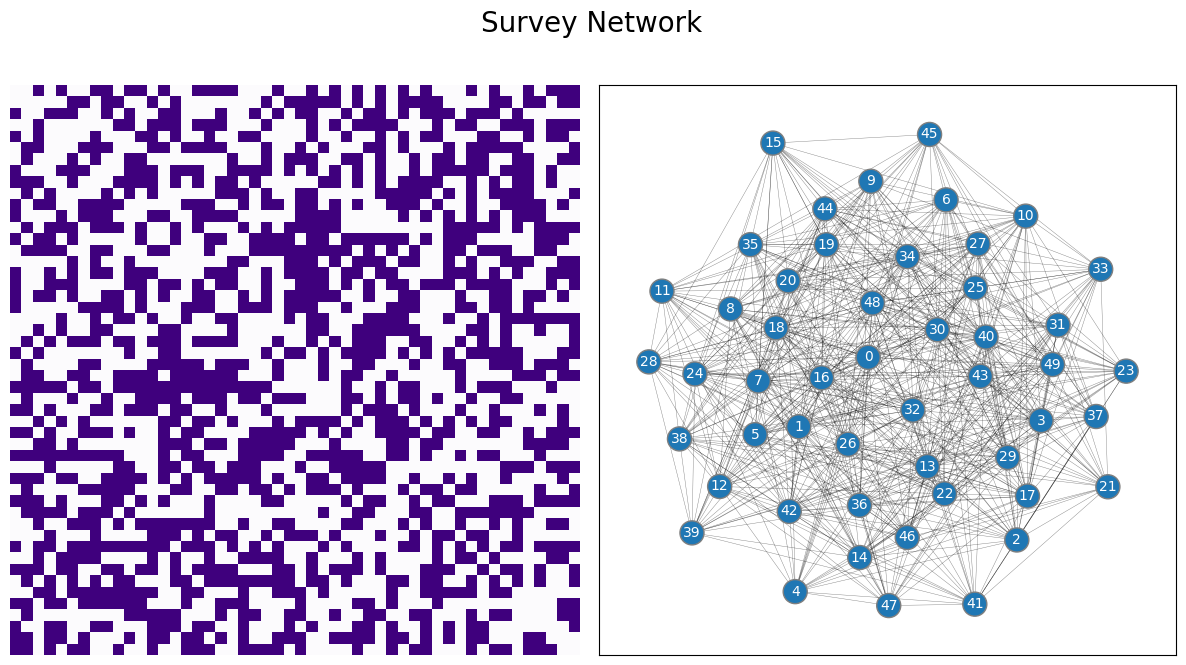

In [3]:
draw_multiplot(Asurvey, title="Survey Network");

The problem is as follows: you took the surveys anonymously, and the only thing you knew was that the surveys were ordered based on the friends lists you obtained. When processing the surveys, you accidentally dropped the stack of papers, and then *totally* lost track of which friends list went with which survey for all but 3 of the students! Given a student for whom you have their corresponding friends list for, can you identify the corresponding node or nodes in the second network (the self-reported survey) that these results correspond to? We'll start back with the permutation code and in the previous section on graph matching in {numref}`ch8:gm`:

In [4]:
def make_permutation(n):
    """
    A function that generates a permutation for n elements.
    """
    # the initial row/column of what is going to be permuted.
    seed_indices = np.arange(n)
    # the "permuted" row/column that the corresponding seed will 
    # end up at
    dest_indices = np.random.permutation(n)
    # initialize permutation matrix
    P = np.zeros((n,n))
    # and fill in accordingly
    P[dest_indices, seed_indices] = 1
    return P

def gen_seeds(P, n_seeds):
    """
    A function to generate n_seeds seeds for a pair of matrices A and P^TBP
    which are initially matched, but P has been applied to permute the nodes
    of B.
    """
    n = P.shape[0]
    # obtain n_seeds random seeds from 1:n
    seeds = np.random.choice(n, size=n_seeds, replace=False)
    # use the permutation matrix to find where each seed was permuted to
    seeds_permuted = [np.where(P[i, :] == 1)[0][0] for i in seeds]
    return seeds, seeds_permuted

np.random.seed(1234)
# shuffle the surveys
P = make_permutation(n)
Asurvey_shuffled = P.T @ Asurvey @ P

# choose which of the 50 nodes will be seeds from social network
nseeds = 4
np.random.seed(1234)
soc_seeds, survey_seeds = gen_seeds(P, nseeds)
print(soc_seeds)
print(survey_seeds)

[37 45  6 44]
[0, 1, 2, 3]


To better understand this problem better, let's explore how this problem looks a lot like two problems we've seen already. 

This looks a lot like the vertex nomination problem in {numref}`ch7:vn` because you have one node of interest, and you want to identify a set of nodes that look "similar" to this node. By "similar", we mean that you want the set of nodes that you identify to have patterns that look a lot like this node (the *nominee* nodes). This problem is different from the vertex nomination problem because the nominees are nodes from the self-reported survey network, and *not* from the social networking friends list network.

This problem looks like the seeded graph matching problem in {numref}`ch8:gm`, too, which you just learned about in the preceding section. This is because you have two networks (the social networking friends list network and the self-reported friend survey network), and you know a *node correspondance* for 5 of the nodes in the network (the 5 students you still have the names of). This problem is different from the seeded graph matching problem because don't necessarily need to match the whole network, you just want to find candidate nodes for a small subset of nodes in the network.

Together, this problem is known as the vertex nomination via seeded graph matching problem, or VNSGM, for short {cite:p}`Patsolic2020Jun`.

```{figure} ../../Images/vnsgm.png
---
align: center
name: graphbook-mod
---
The graphic illustrates the two-graph seeded vertex nomination problem. You have two sets of nodes, one for the social network (green) and one for the self-reported survey (orange). Amongst these nodes, you have a subset of nodes (squares) for which there exists a corresponding matched seed in the second network (dashed lines). For our node of interest in the social network (yellow star), you seek to identify a set of nominee nodes in the survey network (red circles).
```

## Soft Seeded Graph Matching (SoftSGM)

The soft seeded graph matching algorithm (`SoftSGM`) is a slight modification of the `SGM` algorithm you learned about previously. Instead of computing *one* graph matching, with soft seeded graph matching, you compute *many*. You do this by running `SGM` whatever number of times you want, exactly like you did previously, but the key is you use *different* starting positions. If we remember from the last section, the `SGM` and `GM` algorithms were run using gradient descent, and the key is that gradient descent will tend towards *good* solutions, but not necessarily the global *best* solutions. This means that for each different starting position, you might end up with a similar graph matching between your two networks, but not necessarily *identical*. You run `SoftSGM` as follows:

```{admonition} Soft Seeded Graph Matching (SoftSGM)
Given a network $A^{(1)}$ with $n_1$ nodes, a network $A^{(2)}$ with $n_2$ nodes, and a number of repetitions $R$, you take the following procedure:
1. For $r$ in $1:R$:
    + Run $SGM(A^{(1)}, A^{(2)})$, with or without padding, and with or without seeds, with a random starting point.
    + If node $i$ maps to node $j$ in the resulting graph matching, let $p_{ij}^{(r)} = 1$. If node $i$ is not mapped to node $j$ in the resulting graph matching, let $p_{ij}^{(r)} = 0$.
2. For every node $i$ in network $A^{(1)}$ and every node $j$ in network $A^{(2)}$, let $p_{ij} = \frac{1}{R} \sum_{r = 1}^R p_{ij}^{(r)}$ be the fraction of times that node $i$ is mapped to node $j$ across all $R$ graph matchings.

You are left with a matrix $P$ with $n_1$ rows and $n_2$ columns, whose entries are the $p_{ij}$ that you just computed.
```

Basically, the idea is that if a node $i$ in $A^{(1)}$ matches *really well* with a node $j$ in network $A^{(2)}$, multiple or even many graph matchings will produce a matching in which $p_{ij}^{(r)}$ is one. This will lead to $p_{ij}$ tending to have a higher value. On the other hand, if a node $i$ in $A^{(1)}$ is very dissimilar from a node $j$ in network $A^{(2)}$, then few or even no matchings will produce a matching in which $p_{ij}^{(r)}$ is one. This will lead to $p_{ij}$ tending to take a small (or zero) value.

## Using SoftSGM to approach VNSGM

To obtain a list of the best nominees for a node $i$, all you have to do is look at the corresponding $i^{th}$ row of $P$, and take the columns of the $i^{th}$ row that have the highest values! These entries will correspond to the nodes of $A^{(2)}$ that node $i$ tended to be matched with most frequently over our successive graph matchings.

It is easy to run `VNviaSGM` using graspologic to overcome the VNSGM problem. To start, you need to define a node of interest, or a vertex of interest (VOI), which is the node which you will look for the best nominees for in your social network. To do this, let's pick one of the nodes from your social network which is not a seed chosen in the network, and take a look at which node should have a high score in the nomination list (its *correct* match):

In [5]:
nodes = np.arange(0, n)

np.random.seed(1234)
nonseed_vertices = nodes[~np.in1d(nodes, soc_seeds)]
voi = int(nonseed_vertices[np.random.choice(len(nonseed_vertices), 1)])
print("VOI in social network: {:d}".format(voi))
print("Corresponding match for VOI in survey network: {:d}".format(int(np.where(P[voi,:] == 1)[0])))

VOI in social network: 20
Corresponding match for VOI in survey network: 18


So if we are successful, `VNviaSGM` should indicate that the corresponding match for the VOI in the shuffled survey network has a high soft assignment score. We'll do this by printing the soft assignment scores, and looking at the top five entries for our VOI ranked by their soft assignment scores. Let's test this out:

In [6]:
from graspologic.nominate import VNviaSGM

# nrep is the number of permutations to perform
# when nrep is higher, the assignments will be more precise
nrep = 1000
vn_sgm = VNviaSGM(graph_match_kws = {'padding': 'adopted'}, n_init=nrep)

def print_nominees(vn_noms, n_nominees=5):
    """
    A function to properly organize and round the nominees.
    """
    for i in range(0, n_nominees):
        print("Node {:d}, soft assignment score of {:.3f}".format(int(vn_noms[i, 0]), vn_noms[i, 1]))
    return

nominees = vn_sgm.fit_predict(Asoc, Asurvey_shuffled, voi, [soc_seeds, survey_seeds])
print_nominees(nominees, n_nominees=5)

Node 18, soft assignment score of 1.000
Node 48, soft assignment score of 0.000
Node 47, soft assignment score of 0.000
Node 23, soft assignment score of 0.000
Node 22, soft assignment score of 0.000


As we can see, the correct match for the VOI is identified as the node with the highest soft assignment score.